## Task 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Считаем и отобразим данные

In [3]:
with np.load('data.npz') as data:
    A, C = data['A'], data["C"]

((25, 60), (1500, 816))

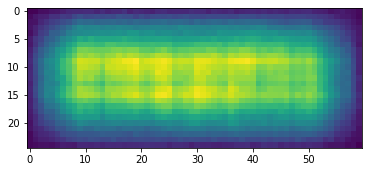

In [4]:
plt.imshow(A)
A.shape, C.shape

In [5]:
def mat2vec(A):
    h, w = A.shape
    a = np.zeros(h*w, dtype=A.dtype)
    A = np.flipud(A) 
    for i, row in enumerate(A):
        a[i*w:i*w+w] = row
    return a

In [6]:
def vec2mat(a, shape):
    h, w = shape
    A = np.zeros(shape, dtype=a.dtype)
    for i in range(h):
        A[i, :] = a[i*w:i*w+w]
    return np.flipud(A)

Посмотрим, как наш фильтр действует на картину

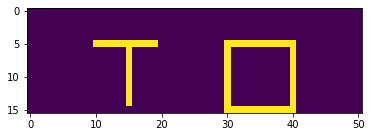

In [7]:
X = np.zeros((16,51))
X[5:15,15] = 1
X[5:15,30] = 1
X[5:15,40] = 1
X[5,10:20] = 1
X[5,30:41] = 1
X[15,30:41] = 1
plt.imshow(X)
plt.show()

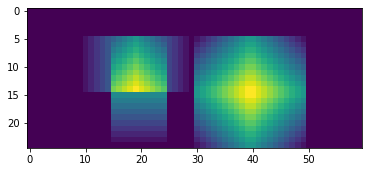

In [8]:
x = mat2vec(X)
plt.imshow(vec2mat(C @ x, (25, 60)))
plt.show()

Теперь найдем SVD разложение нашей матрицы C

In [10]:
u, s, vh = np.linalg.svd(C, full_matrices=False)
C.shape, s.shape

((1500, 816), (816,))

По размеру C видно, что система уравнений $a = Ca_0$ переопределена.

Будем решать ее методом наименьших квалратов, так как наша ошибка распределена норамльно. Для начала найдем решение "влом", с помощью псевдообратной матрицы С.

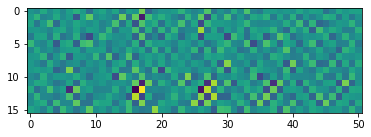

In [12]:
a = mat2vec(A)
a0 = np.linalg.pinv(C) @ a
A0 = vec2mat(a0, (16, 51))
plt.imshow(A0)
plt.show()

Ничего не видно и не понятно. Попробуем оставить в разложении матрицы С только первые n сингулярных значений.

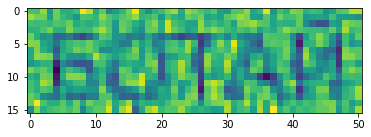

In [13]:
n = 370
s0 = np.zeros(816)
s0[:n] = s[:n]
C0 = np.dot(u, np.dot(np.diag(s0), vh))

A0_guess = vec2mat(np.linalg.pinv(C0) @ a, (16, 51))
plt.imshow(A0_guess)
plt.show()

Уже так можно прочитать, что написанно. Можно попробовать увеличить контрастность.

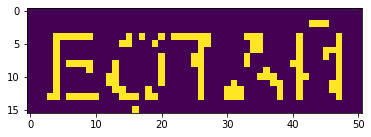

In [14]:
A1 = np.zeros((16, 51))
for i in range(A0_guess.shape[0]):
    for c in range(A0_guess.shape[1]):
        if A0_guess[i][c] < 110:
            A1[i][c] = 1
plt.imshow(A1)

Надпись предельно ясна, идем ботать

## Task 2

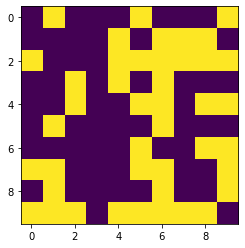

In [282]:
N = 10
np.random.seed(42)
L = np.random.randint(0, 2, (N, N))
L[:,3] = np.zeros(N)
for i in range(N):
    L[i,i] = 0
#L = np.array([[0,0,0,0], [1,0,1,1], [1,0,0,0], [1,0,0,0]])
plt.imshow(L)
plt.show()

In [283]:
import networkx as nx

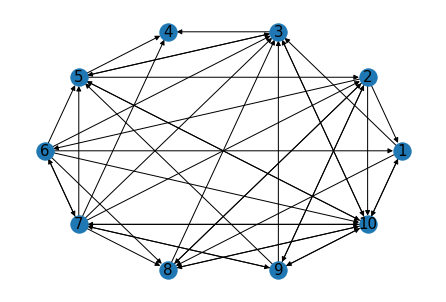

In [284]:
G = nx.from_numpy_matrix(np.array(L.T), create_using=nx.MultiDiGraph())
pos = nx.circular_layout(G)
nx.draw_circular(G)
labels = {i : i + 1 for i in G.nodes()}
nx.draw_networkx_labels(G, pos, labels, font_size=15)
plt.show()

Замечаем, что ответ должен быть 10

Найдем наш вектор J

In [296]:
J = np.array(list(map(lambda x : np.sum(x), L.T)))
J

array([3, 5, 3, 0, 4, 6, 8, 3, 5, 6])

Теперь создадим матрицу G

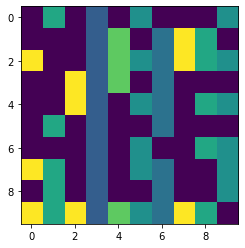

In [297]:
G = np.zeros((N, N))
for i in range(N):
    if J[i] != 0:
        G[:,i] = L[:,i] / J[i]
    else:
        G[:,i] = 1/N
plt.imshow(G)
plt.show()

Для ускорения сходимости алгоритма немного изменим матрицу G

In [298]:
beta = 0.8
G = beta * G + (1 - beta)/N * np.ones(N)[:,np.newaxis] @ np.ones(N)[np.newaxis, :]

In [299]:
eival, eivec = np.linalg.eig(G)

In [300]:
print('Наиболее подходящий сайт имеет номер', np.argmax(abs(eivec[:,0])) + 1)

Наиболее подходящий сайт имеет номер 10


Что сходится с правильным ответом

In [2]:
from scipy import sparse
def dataset2csr(filename, nodes, edges):
    rows = []; cols = []    
    with open(filename, 'r') as f:
        for line in f.readlines()[4:]:
            o, d = (int(x)-1 for x in line.split())
            rows.append(d)
            cols.append(o)
    return(sparse.csr_matrix(([True]*edges, (rows, cols)), shape=(nodes, nodes)))

### Немного теории  

Для ускорения метода не будем явно создавать матрицу G

$$G = \beta \frac{l_{ij}}{J_j}+ \frac{1 - \beta}{N} e e^T$$

В нашем методе мы генерируем случайный вектор u и действуем на него матрицей G:

$$G\vec{u} = \beta \frac{l_{ij}}{J_j} \vec{u}+ \frac{1 - \beta}{N} e e^T\vec{u}$$

То есть мы можем не создавать новую матрицу $\frac{l_{ij}}{J_j}$ и $e e^T$, а просто складывать вектора. Сложность представляет первое слогаемое. Не очень понятно, как его представить в нужной форме.

Заметим, что преобразование нормировки (без учета замены нулей на 1/N) можно представить как $l * diag(1/J)$. Остается учесть то, что мы заменяем колонки, заполненые только нулями 1/N. Пусть $H$ - матрца, на j-ых столбцах которой значения 1/N, если J[ j ] = 0. Тогда нужная нам матрица $G' = l * diag(J) + H$

Расспишем, как мы умножаем эту матрицу на вектор u.

$$G' \vec{u} = \beta (l*diag(1/J) \vec{u} + H * \vec{u})$$ 

Тогда полное уравнение имеет вид 

$$G \vec{u} = \beta (l*diag(1/J) \vec{u} + H * \vec{u}) + \frac{1 - \beta}{N} e e^T\vec{u} = \beta(l*diag(1/J) \vec{u} + H * \vec{u}) + \vec{e} * \frac{(u_1 + u_2 + ... + u_N) * (1 - \beta)}{N}$$

$$G \vec{u} = \beta(l*np.multiply(\vec{1/J}, \vec{u}) + H * \vec{u}) + \vec{e} * \frac{(u_1 + u_2 + ... + u_N) * (1 - \beta)}{N}$$

Так же легко представить $H * \vec{u} = \vec{e}*\frac{\sum_j u_j}{N}$, где j - индекс столбцов, заполненых нулями. Тогда в итоге:

$$G \vec{u} = \beta l*np.multiply(\vec{1/J}, \vec{u}) + \vec{e} * \frac{(u_1 + u_2 + ... + u_N) * (1 - \beta) + \beta \sum_j u_j}{N}$$

Для начала проверим нашу модель на простом примере, который мы разбирали на семинаре. Граф из 4-х вершин.

In [122]:
beta = 0.8

In [124]:
N = 4
l = np.array([[0,0,0,0], [1,0,1,1], [1, 0, 0, 0], [1, 0,0,0]])
J = np.sum(l,axis=0)
j_index = np.where(J == 0)[0]
Jw = np.zeros(N)
Jw[np.nonzero(J)] = (1/(J[np.nonzero(J)]))

In [125]:
np.random.seed(42)
u = np.random.randint(2, size=(N))
u = u/np.linalg.norm(u)
u_pre = np.zeros(N)
count = 0
while np.linalg.norm(u_pre - u, ord=1) > 10**(-4):
    u_pre = u.copy()
    u = beta * (np.squeeze(np.asarray(l @ np.multiply(Jw, u).T)) + (np.ones(N) * ((np.sum(u) * (1/beta - 1) + np.sum(u[j_index])) / N)))
    u = u/np.linalg.norm(u)
    count += 1
print('Количество итераций', count)
print(u)
print('Максимальный Page Rank =', np.max(u), 'ему соответсвует страница №',  np.argmax(u) + 1)
print('Собственное значение =', np.linalg.norm(beta * (np.squeeze(np.asarray(l @ np.multiply(Jw, u).T)) + (np.ones(N) * ((np.sum(u) * (1/beta - 1) + np.sum(u[j_index])) / N)))))

Количество итераций 11
[0.25772274 0.8487851  0.32645278 0.32645278]
Максимальный Page Rank = 0.8487851032089523 ему соответсвует страница № 2
Собственное значение = 0.9999960572684939


Теперь начнем работать с базой данных

In [171]:
from sys import getsizeof
l = dataset2csr(filename='web-Stanford.txt', nodes = 281903, edges=2312497)
N = 281903
print(getsizeof(l), 'байтов')

56 байтов


In [172]:
J = sparse.csr_matrix.sum(l, axis=0)
j_index = np.where(J == 0)[1]

In [193]:
Jw = np.zeros(N)
Jw[np.nonzero(J)[1]] = np.asarray(1/J[np.nonzero(J)])
Jw

array([0.5       , 0.03225806, 1.        , ..., 1.        , 0.14285714,
       0.14285714])

In [196]:
%%time
np.random.seed(42)
u = np.random.randint(2, size=(N))
u = u/np.linalg.norm(u)
u_pre = np.zeros(N)
count = 0
while np.linalg.norm(u_pre - u, ord=1) > 10**(-4):
    u_pre = u.copy()
    u = beta * (np.squeeze(np.asarray(l @ np.multiply(Jw, u).T)) + (np.ones(N) * ((np.sum(u) * (1/beta - 1) + np.sum(u[j_index])) / N)))
    u = u/np.linalg.norm(u)
    count += 1
print('Количество итераций', count)
print('Максимальный Page Rank =', np.max(u), 'ему соответсвует страница №',  np.argmax(u) + 1)
print('Собственное значение =', np.linalg.norm(beta * (np.squeeze(np.asarray(l @ np.multiply(Jw, u).T)) + (np.ones(N) * ((np.sum(u) * (1/beta - 1) + np.sum(u[j_index])) / N)))))

Количество итераций 47
Максимальный Page Rank = 0.47425124822943654 ему соответсвует страница № 89073
Собственное значение = 0.9999998801106876
CPU times: user 3.7 s, sys: 72 ms, total: 3.77 s
Wall time: 636 ms


Посчитаем время полного выполнения всего кода

In [199]:
%%time
def dataset2csr(filename, nodes, edges):
    rows = []; cols = []    
    with open(filename, 'r') as f:
        for line in f.readlines()[4:]:
            o, d = (int(x)-1 for x in line.split())
            rows.append(d)
            cols.append(o)
    return(sparse.csr_matrix(([True]*edges, (rows, cols)), shape=(nodes, nodes)))

l = dataset2csr(filename='web-Stanford.txt', nodes = 281903, edges=2312497)
N = 281903
J = sparse.csr_matrix.sum(l, axis=0)
j_index = np.where(J == 0)[1]
Jw = np.zeros(N)
Jw[np.nonzero(J)[1]] = np.asarray(1/J[np.nonzero(J)])
np.random.seed(42)
u = np.random.randint(2, size=(N))
u = u/np.linalg.norm(u)
u_pre = np.zeros(N)
count = 0
while np.linalg.norm(u_pre - u, ord=1) > 10**(-4):
    u_pre = u.copy()
    u = beta * (np.squeeze(np.asarray(l @ np.multiply(Jw, u).T)) + (np.ones(N) * ((np.sum(u) * (1/beta - 1) + np.sum(u[j_index])) / N)))
    u = u/np.linalg.norm(u)
    count += 1
print('Количество итераций', count)
print('Максимальный Page Rank =', np.max(u), 'ему соответсвует страница №',  np.argmax(u) + 1)
print('Собственное значение =', np.linalg.norm(beta * (np.squeeze(np.asarray(l @ np.multiply(Jw, u).T)) + (np.ones(N) * ((np.sum(u) * (1/beta - 1) + np.sum(u[j_index])) / N)))))

Количество итераций 47
Максимальный Page Rank = 0.47425124822943654 ему соответсвует страница № 89073
Собственное значение = 0.9999998801106876
CPU times: user 6.69 s, sys: 261 ms, total: 6.95 s
Wall time: 3.94 s


## Task 3

Запишем уравнения ньютона для k-го атома.

Пусть на нечетных позициях атомы массы m, а на четных M. Тогда запищем уравнения Ньютона для них:

$$m x_{k+1}'' = k(x_k - 2 x_{k+1}+ x_{k+2})$$
$$M x_k'' = k(x_{k-1} -2 x_k + x_{k+1})$$

Тогда в матричной форме можем записать:

$$\frac{d^2\vec{x}}{dt^2} + k A\vec{x} = 0$$
Запищем как выглядит матрица А:

\begin{equation*}
A = \left(
\begin{array}{cccc}
2 & -1 & 0 & \ldots & -1\\
-1/2 & 1 & -1/2 & \ldots & 0\\
0 & -1 & 2 &\ldots & 0\\
\vdots & \vdots & \ddots & \vdots\\
0 & 0 & \ldots & 2 & -1\\
-1/2 & 0 & \ldots & -1/2 & 1
\end{array}
\right)
\end{equation*}

В левом нижнем и правом верхнем углу не нули, так как цепочка замкнута.

In [2]:
def made_matrix_A (N):
    A = np.diag([2,1]  * N) + np.diag(([-0.5, -1] * N)[:-1], -1) + np.diag(([-1, -0.5] * N)[:-1], 1)
    A[0, 2*N-1] = -1
    A[2*N-1, 0] = -0.5
    return A
made_matrix_A(2)

array([[ 2. , -1. ,  0. , -1. ],
       [-0.5,  1. , -0.5,  0. ],
       [ 0. , -1. ,  2. , -1. ],
       [-0.5,  0. , -0.5,  1. ]])

-------------------------------

In [7]:
N = 1000

In [8]:
A = made_matrix_A(N)
eigval, eigvec = np.linalg.eig(A)

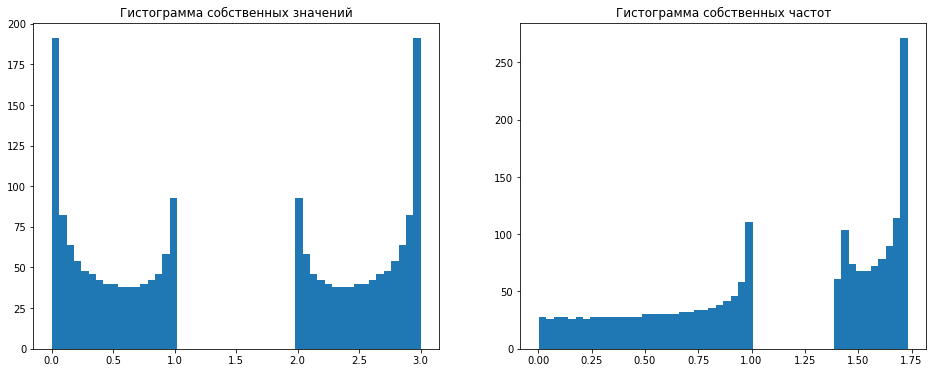

In [15]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.hist(eigval, bins=50)
plt.title('Гистограмма собственных значений')

plt.subplot(1, 2, 2)
plt.hist(eigval[1:]**0.5, bins=50)
plt.title('Гистограмма собственных частот')
plt.show()

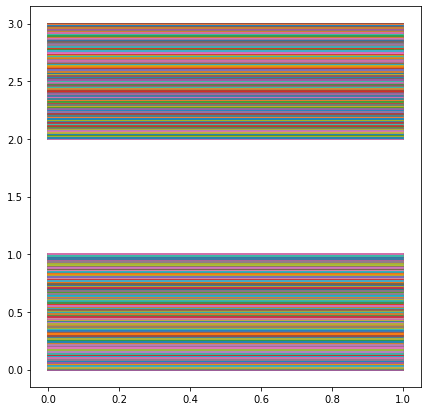

In [36]:
plt.figure(figsize=(7,7))
for i in range(2*N):
    plt.plot([0,1], [eigval[i], eigval[i]])
plt.show()

In [16]:
eigval

array([-7.19465513e-16,  2.99621247e+00,  2.99652134e+00, ...,
        2.37434431e-03,  1.05090933e-02,  3.29846765e-02])

In [17]:
eigvec[:,0]

array([0.02236068, 0.02236068, 0.02236068, ..., 0.02236068, 0.02236068,
       0.02236068])

In [39]:
(A - np.identity(2*N)*eigval[0]) @ eigvec[:,0]

array([-3.40005801e-16,  1.63064007e-16, -7.21644966e-16, ...,
       -1.68268177e-16,  3.60822483e-16, -3.43475248e-16])

--------------------

In [19]:
def find_sec (ar):
    one = np.max(ar)
    minn = np.min(ar)
    for i in range(len(ar)):
        if (ar[i] < one) & (ar[i] != minn):
            one = ar[i]
            k = i
    return k

In [20]:
eimax = eigvec[:,np.argmax(eigval)]
eimin = eigvec[:,np.argmin(eigval)]

eimnin_next = eigvec[:,find_sec(eigval)]

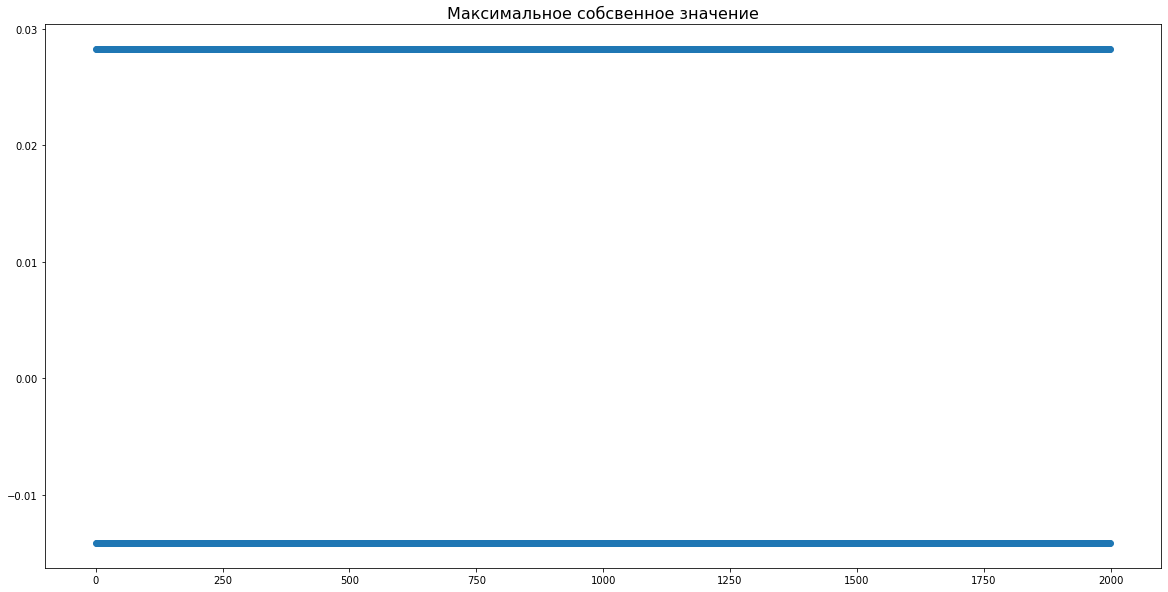

In [21]:
plt.figure(figsize=(20,10))
plt.scatter(range(len(eimax)), eimax)
plt.title('Максимальное собсвенное значение', fontsize=16)
plt.show()

<Figure size 1440x720 with 0 Axes>

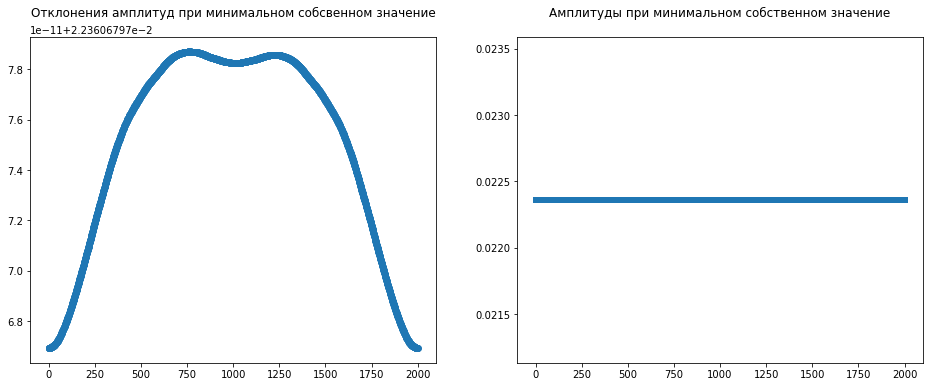

In [39]:
plt.figure(figsize=(20,10))

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.scatter(range(len(eimin)), eimin)
plt.title('Отклонения амплитуд при минимальном собсвенном значение', pad = 20)

plt.subplot(1, 2, 2)
plt.plot([0, 2000], [np.mean(eimin)]*2, linewidth=6)
plt.title('Амплитуды при минимальном собственном значение', pad = 20)
plt.show()

Нарисуем минимум и максимум на одном графике

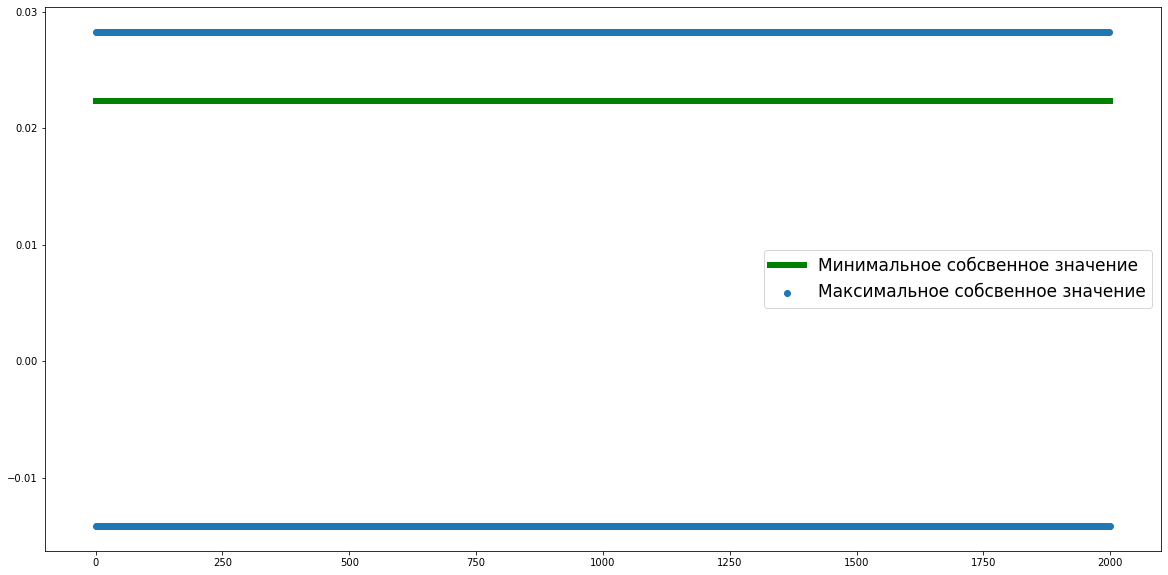

In [41]:
plt.figure(figsize=(20,10))
plt.scatter(range(len(eimax)), eimax, label='Максимальное собсвенное значение')
plt.plot([0, 2000], [np.mean(eimin)]*2, linewidth=6, label='Минимальное собсвенное значение', color='green')
plt.legend(fontsize=17)
plt.show()

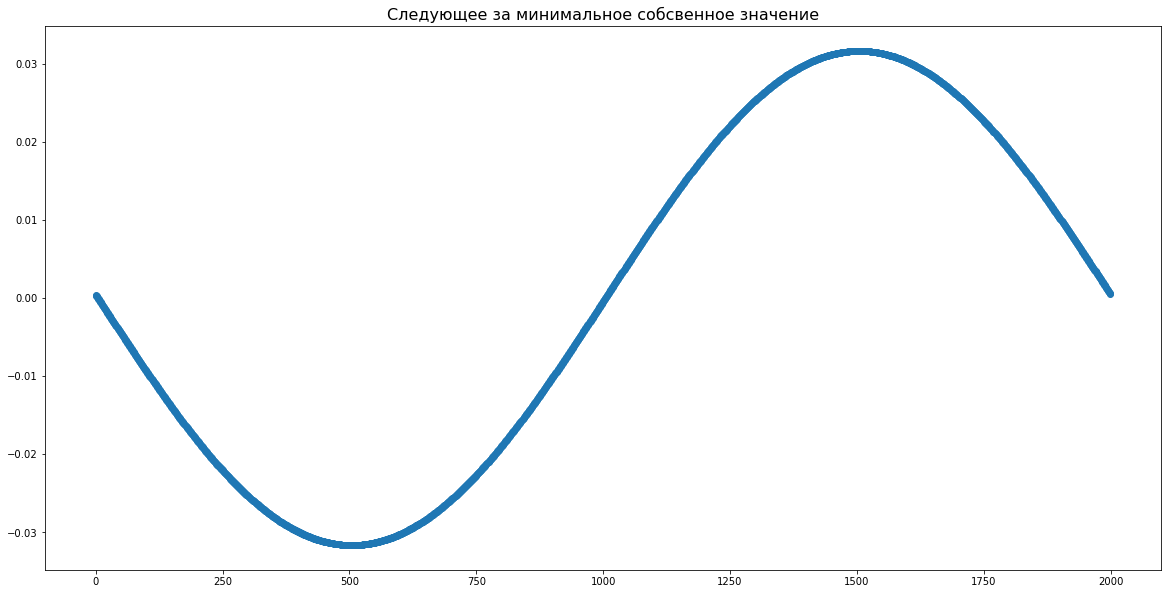

In [44]:
plt.figure(figsize=(20,10))
plt.scatter(range(len(eimin)), eimnin_next)
plt.title('Следующее за минимальное собсвенное значение', fontsize=16)
plt.show()

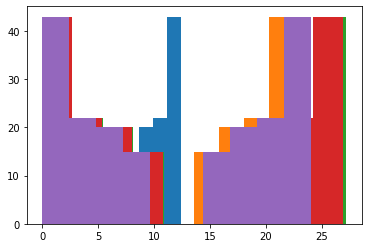

In [49]:
A = made_matrix_A(100)
for i in range(5):
    k = np.random.random()*9 + 1
    A_k = k*A
    eigenvals_k = np.linalg.eigvals(A_k)
    eigen = np.linalg.eig(A_k)
    plt.hist(eigenvals_k)
plt.show()

Видно, что коэффициент просто увеличивает масштабы, не меняя картины в целом.

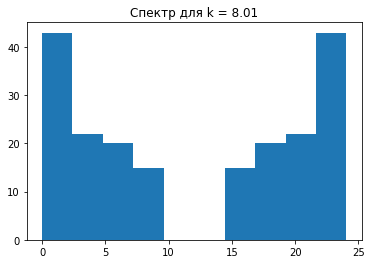

In [50]:
plt.title("Спектр для k = " + str(k)[:4])
plt.hist(eigenvals_k)
plt.show()

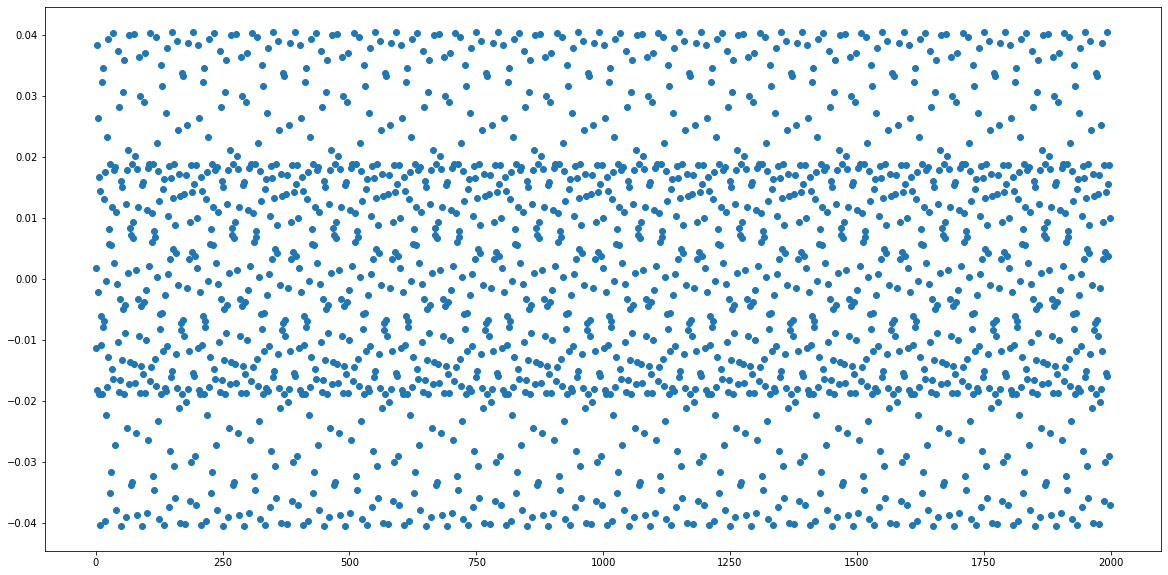

In [47]:
k = 8.1
B = made_matrix_A(1000) * k
eigval_b, eigvec_b = np.linalg.eig(A)
plt.figure(figsize=(20,10))
plt.scatter(range(len(eigvec_b[402])), eigvec_b[:,402])
plt.show()

In [70]:
N = 3
n = 3
A = np.ones((N, N))
for i in range(N):
    A[i, N - i - 1] = -n
A, np.linalg.det(A)

(array([[ 1.,  1., -3.],
        [ 1., -3.,  1.],
        [-3.,  1.,  1.]]),
 16.000000000000007)

In [74]:
sign = []
for N in range (20):
    A = np.ones((N, N))
    for i in range(N):
        A[i, N - i - 1] = -N
    sign.append(np.sign(np.linalg.det(A)))

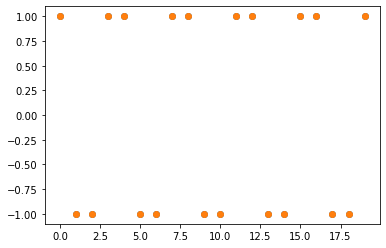

In [91]:
plt.scatter(range(20), sign)
plt.scatter(range(20), [(-1)**(k*(k+1)/2) for k in range(20)])